In [1]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import random
from torch.utils.data.dataset import TensorDataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
from torch.optim import Adam
from pytorch_lightning import Trainer
import os
import numpy as np
import pandas as pd
from os.path import join
from typing import Optional
from config import processed_data_path
from sklearn.utils import shuffle
from tqdm.notebook import tqdm
from optuna.integration import PyTorchLightningPruningCallback
from scipy.stats import wasserstein_distance 
import joblib
import optuna
%matplotlib inline
from matplotlib import pyplot as plt
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.metrics import r2_score

class _dataset(Dataset): #
    def __init__(self, variant, category, random_seed=42, tensor=True):
        """ 
        variant -> 'VLQ_HG', 'VLQ_SEM_HG', 'bkg', 'FCNC'
        category -> 'train, validation', 'test', 'all'
        tensor -> if true will return the data as a tensor, if False will return as a DataFrame
        """
        # TODO: Improve efficiency/handle names
        
        # Sanity checks
        assert variant in {'VLQ_HG', 'VLQ_SEM_HG', 'bkg', 'FCNC'}, "Invalid variant!"
        assert category in {'train', 'validation', 'test', 'all'}, "Invalid category!"

        # With specified variant, get data
        file = join(processed_data_path, variant + ".csv")
        data = pd.read_csv(file, index_col=0)

        # Shuffle the dataframe
        data = data.sample(frac=1, random_state=random_seed).reset_index(drop=True)

        # This will equally devide the dataset into 
        # train, validation and test
        train, validation, test = np.split(data.sample(frac=1), [int(len(data)*(1/3)), int(len(data)*(2/3))])
        
        if category == "train":
            data = train
        elif category == "validation":
            data = validation
        elif category == "test":
            data = test
        elif category == "all":
            del train, validation, test
            self.data = data
        
        # This data we want on a seperate variable
        if category != "all":
            # Weights
            if tensor:
                self.weights = torch.from_numpy(data["weights"].to_numpy(dtype=np.float32))
            else:
                self.weights = data["weights"]
            # Name
            self.name = data["name"]

            data.drop(["name", "weights"], axis=1, inplace=True)
            # Data
            if tensor:
                self.data = torch.from_numpy(data.to_numpy(dtype=np.float32))
            else:
                self.data = data
            self.n_samples = data.shape[0]


    def __getitem__(self, index):
        return self.data[index], self.weights[index]

    def __len__(self):
        return self.n_samples

    def all_data(self):
        return self.data

## Defining the model

In [2]:
class VAE(pl.LightningModule):
    def __init__(self, trial, batch_size, dataset):
        """
        Args:
        - > variant e {'VLQ_HG', 'VLQ_SEM_HG', 'bkg', 'FCNC'}; it's the type of data
        - > hidden_size : Latent Hidden Size
        - > alpha : Hyperparameter to control the importance of
        reconstruction loss vs KL-Divergence Loss
        - > lr : Learning Rate, will not be used if auto_lr_find is used.
        - > dataset : Dataset to used
        """
        super().__init__()
        self.dataset = dataset
        self.batch_size = batch_size
        self.hparams.batch_size = batch_size
        self.hidden_size = trial.suggest_int("hidden_size", 2, 30)
        hidden_size = self.hidden_size # yes I am lazy
        self.lr = trial.suggest_float("lr", 1e-6, 1e-2, log=True)
        self.alpha = trial.suggest_int("alpha", 1, 3000)
        self.best_score = None
        ## Architecture
        # Encoder
        n_layers_encoder = trial.suggest_int("n_layers_encoder", 1, 5)
        layers = []

        in_features = 69
        for i in range(n_layers_encoder):
            out_features = trial.suggest_int("n_units_encoder_l{}".format(i), 5, 256)
            layers.append(nn.Linear(in_features, out_features))
            layers.append(nn.LeakyReLU())

            in_features = out_features

        # Ultima layer
        layers.append(nn.Linear(in_features, hidden_size))
        layers.append(nn.LeakyReLU())

        self.encoder = nn.Sequential(*layers)

        self.hidden2mu = nn.Linear(hidden_size, hidden_size)
        self.hidden2log_var = nn.Linear(hidden_size, hidden_size)
        
        # Decoder
        n_layers_encoder = trial.suggest_int("n_layers_decoder", 1, 5)
        layers = []

        in_features = hidden_size
        for i in range(n_layers_encoder):
            out_features = trial.suggest_int("n_units_decoder_l{}".format(i), 5, 256)
            layers.append(nn.Linear(in_features, out_features))
            layers.append(nn.LeakyReLU())

            in_features = out_features

        # Ultima layer
        layers.append(nn.Linear(in_features, 69))
        layers.append(nn.LeakyReLU())

        self.decoder = nn.Sequential(*layers)

        ## Load bkg data for
        # being used at self.on_epoch_end
        #self.bkg = _dataset(category='test', variant='bkg', tensor=False).all_data().to_numpy()

    def encode(self, x):
        # Pass through encoder
        out = self.encoder(x)
        mu = self.hidden2mu(out)
        log_var = self.hidden2log_var(out)
        return mu, log_var

    def decode(self, x):
        # Pass through encoder
        return self.decoder(x)

    def reparametrize(self, mu, log_var):
        # Reparametrization Trick
        # It outputs a sample of the dist.
        # mu -> average | log_var -> std
        
        log_var = torch.exp(0.5*log_var)
        z = torch.randn(size=(mu.size(0), mu.size(1))) # log_var, normal distribution
        z = z.type_as(mu)
        return mu + log_var*z

    def forward(self, x):
        # Pass through encoder
        mu, log_var = self.encode(x)
        # Reparametrization Trick
        hidden = self.reparametrize(mu, log_var)
        # Pass through decoder
        output = self.decoder(hidden)

        return mu, log_var, output, hidden

    def training_step(self, batch, batch_idx):
        x, weights = batch
        # Pass
        mu, log_var, x_out, _ = self.forward(x)

        # Losses
        kl_loss = (-0.5*(1+log_var - mu**2 -
                         torch.exp(log_var)).sum(dim=1)).mean(dim=0)

        recon_loss_criterion = nn.MSELoss()
        recon_loss = recon_loss_criterion(x, x_out)

        loss = recon_loss*self.alpha + kl_loss

        # Weights on final loss
        loss = (weights * loss) / weights.sum()
        loss = torch.mean(loss, dtype=torch.float32)

        if loss.isnan().any():
            raise KeyboardInterrupt

        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch):
        ### WIP
        x = batch
        mu, log_var, x_out, hidden = self.forward(x)

        # Loss
        kl_loss = (-0.5*(1+log_var - mu**2 -
                         torch.exp(log_var)).sum(dim=1)).mean(dim=0)
        recon_loss_criterion = nn.MSELoss()
        recon_loss = recon_loss_criterion(x, x_out)
        loss = recon_loss*self.alpha + kl_loss

        return  mu, log_var, x_out, hidden

    def validation_step(self, batch, batch_idx):
        with torch.no_grad():
            x, weights = batch
            # Pass
            mu, log_var, output, hidden = self.forward(x)

            x = x.cpu().numpy()
            output = output.cpu().numpy()

            #print("Input", np.isnan(x).any())
            #print("Output", np.isnan(output).any())


            try:
                objective_score = r2_score(x,output)
            except:
                print("\n[-] Erro! ")
                # objective_score = np.inf
                raise KeyboardInterrupt

            self.log('objective_score', objective_score, prog_bar=True)

            if self.best_score is None:
                self.best_score = objective_score
            elif objective_score > self.best_score:
                self.best_score = objective_score
            else:
                pass


    def configure_optimizers(self):
        return Adam(self.parameters(), lr=self.lr)

    # Functions for dataloading
    def train_dataloader(self):
        train_set = _dataset(self.dataset, category="train")
        return DataLoader(train_set, batch_size=self.batch_size, num_workers=12)

    def val_dataloader(self):
        val_set = _dataset(self.dataset, category='test')
        return DataLoader(val_set, batch_size=self.batch_size, num_workers=12)


In [3]:
def objective(trial):

    name = "r2_trial_{}".format(trial.number)

    logger = TensorBoardLogger("lightning_logs", name=name)

    max_epochs=trial.suggest_int("max_epochs", 50, 500, step=5)
    patience=trial.suggest_int("patience", 50, 200, step=5)

    trainer = pl.Trainer(
        gpus=1,
        logger=logger,
        max_epochs=max_epochs,
        precision=16,
        #check_val_every_n_epoch=5,
        callbacks=[
            EarlyStopping(monitor="objective_score", patience=patience, mode="max"),
            ModelCheckpoint(dirpath="models", filename=name, monitor="objective_score", mode="max")]
    )

    model = VAE(trial, dataset = "bkg", batch_size=4048)
    trainer.fit(model)

    return model.best_score

## Training

In [4]:
study = joblib.load("study_r2.pkl")

study = optuna.create_study(direction="maximize", study_name="Optimizing the VAE with r2", storage="sqlite:///r2-optimization.db", load_if_exists=True)
#study.optimize(objective, timeout=2*60*60)#n_trials=200)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

print(" TRIAL NUMBER:", trial.number)



#joblib.dump(study, "study_r2.pkl")

[I 2021-07-04 13:33:08,657] Using an existing study with name 'Optimizing the VAE with r2' instead of creating a new one.
Number of finished trials: 108
Best trial:
  Value: 0.8875963341169449
  Params: 
    alpha: 857
    hidden_size: 27
    lr: 0.0012149609674372648
    max_epochs: 490
    n_layers_decoder: 1
    n_layers_encoder: 3
    n_units_decoder_l0: 225
    n_units_encoder_l0: 100
    n_units_encoder_l1: 92
    n_units_encoder_l2: 195
    patience: 165
 TRIAL NUMBER: 107


### Re-trained the model with some manually fine-tuned h.p    WIP

In [5]:
params = study.best_trial.params

# Manually change them
#params['hidden_size'] = 16
params['max_epochs'] = 1000

# Name of the model
name = "CustomTrain_hidden=16_max_epochs=1000"
params

{'alpha': 857,
 'hidden_size': 27,
 'lr': 0.0012149609674372648,
 'max_epochs': 1000,
 'n_layers_decoder': 1,
 'n_layers_encoder': 3,
 'n_units_decoder_l0': 225,
 'n_units_encoder_l0': 100,
 'n_units_encoder_l1': 92,
 'n_units_encoder_l2': 195,
 'patience': 165}

In [6]:
"""
logger = TensorBoardLogger("lightning_logs", name=name)

trainer = pl.Trainer(
        gpus=1,
        logger=logger,
        max_epochs=params['max_epochs'],
        precision=16,
        check_val_every_n_epoch=5,
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=400),
            ModelCheckpoint(dirpath="models", filename=name, monitor="wassernstein_score", mode="min")]
    )

model = VAE(optuna.trial.FixedTrial(params), dataset = "bkg", batch_size=4048)
trainer.fit(model)
"""

'\nlogger = TensorBoardLogger("lightning_logs", name=name)\n\ntrainer = pl.Trainer(\n        gpus=1,\n        logger=logger,\n        max_epochs=params[\'max_epochs\'],\n        precision=16,\n        check_val_every_n_epoch=5,\n        callbacks=[\n            EarlyStopping(monitor="val_loss", patience=400),\n            ModelCheckpoint(dirpath="models", filename=name, monitor="wassernstein_score", mode="min")]\n    )\n\nmodel = VAE(optuna.trial.FixedTrial(params), dataset = "bkg", batch_size=4048)\ntrainer.fit(model)\n'

### Optuna Graphs

In [7]:
import joblib
study = joblib.load("study_r2.pkl")

In [8]:
optuna.visualization.plot_param_importances(study)

In [9]:
optuna.visualization.plot_intermediate_values(study)

[W 2021-07-04 13:33:11,958] You need to set up the pruning feature to utilize `plot_intermediate_values()`


In [10]:
optuna.visualization.plot_optimization_history(study)

## Anomaly Detection

### Load the model

In [11]:

model = VAE.load_from_checkpoint(
    join('models', f"r2_trial_{study.best_trial.number}.ckpt"),
    trial = optuna.trial.FixedTrial(study.best_trial.params), 
    dataset = "bkg", 
    batch_size=4048)

model.eval()

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=69, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=100, out_features=92, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=92, out_features=195, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=195, out_features=27, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
  )
  (hidden2mu): Linear(in_features=27, out_features=27, bias=True)
  (hidden2log_var): Linear(in_features=27, out_features=27, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=27, out_features=225, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=225, out_features=69, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
  )
)

### Load data

In [12]:
# Sinal
data = pd.concat([
     _dataset(category='all',variant='VLQ_HG').all_data()
    ,_dataset(category='all',variant='VLQ_SEM_HG').all_data()
    ,_dataset(category='all',variant='FCNC').all_data()
    ])

# Bkg
bkg = _dataset(category='test',variant='bkg', tensor=False).all_data()
bkg['name'] = 'background.csv'
data = pd.concat([data, bkg])

data.drop(columns=['weights'], inplace=True)
data.describe()


/home/acujl/.local/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



FatJet_Multi     FatJet1_PT     FatJet2_PT     FatJet3_PT  \
count  527817.000000  527817.000000  527817.000000  527817.000000   
mean        0.000645       0.000882      -0.000312       0.001210   
std         1.000483       0.999427       1.000024       1.002075   
min        -5.319242      -4.101005      -2.998802      -1.426919   
25%        -0.506770      -0.579074      -0.856784      -0.459476   
50%        -0.114884      -0.042601      -0.130506      -0.220869   
75%         0.791427       0.539871       0.706445      -0.171740   
max         8.250492      12.975352      10.765291      19.666985   

          FatJet4_PT     FatJet5_PT   FatJet1_Mass   FatJet2_Mass  \
count  527817.000000  527817.000000  527817.000000  527817.000000   
mean       -0.000361      -0.001084      -0.000450      -0.000290   
std         0.994436       0.945453       1.000003       0.998904   
min        -0.605231      -0.189027      -3.535722      -2.437525   
25%        -0.129339      -0.031524      -0.784905      -0.742107   
50%        -0.096728      -0.024664      -0.071524      -0.331509   
75%        -0.047287      -0.010815       0.634610       0.579215   
max        39.224680     199.702278      19.916800      14.350854   

        FatJet3_Mass   FatJet4_Mass  ...  Electron_Multi   Electron1_PT  \
count  527817.000000  527817.000000  ...   527817.000000  527817.000000   
mean        0.001725      -0.000833  ...        0.000014       0.000018   
std         1.004806       0.977880  ...        0.999428       0.999212   
min        -1.199560      -0.539097  ...       -1.336158      -1.218623   
25%        -0.388786      -0.113399  ...       -0.810386      -0.710694   
50%        -0.193727      -0.086368  ...       -0.781252      -0.572371   
75%        -0.151859      -0.041419  ...        1.198572       0.536095   
max        23.140329      65.085490  ...        4.526157      11.705100   

        Electron2_PT  Electron1_Eta  Electron2_Eta  Electron1_Phi  \
count  527817.000000  527817.000000  527817.000000  527817.000000   
mean        0.000371       0.002386       0.000879       0.000050   
std         1.000566       1.001056       0.998411       0.999658   
min        -0.673532      -4.252402      -5.501854      -2.826970   
25%        -0.534342      -0.005541      -0.004436      -0.004365   
50%        -0.486734       0.000813      -0.000362      -0.000101   
75%         0.183014       0.007525       0.001253       0.008770   
max        14.925601       4.244353       5.473439       2.827633   

       Electron2_Phi  MissingET_MET  MissingET_Phi    ScalarHT_HT  
count  527817.000000  527817.000000  527817.000000  527817.000000  
mean       -0.000056      -0.000070       0.000486       0.000144  
std         0.999480       0.998417       1.000132       0.999953  
min        -4.055191      -1.527783      -1.755112      -2.533251  
25%        -0.000624      -0.663939      -0.865766      -0.705652  
50%         0.001715      -0.272573       0.001261      -0.242011  
75%         0.005244       0.370126       0.867531       0.450885  
max         4.019552      19.050344       1.774882      14.938015  

[8 rows x 69 columns]

## Check if z ~ N(0,1)

In [13]:
_, _, _, hidden = model.test_step(torch.from_numpy(data.drop(columns=['name']).to_numpy(dtype=np.float32)))
hidden = hidden.detach().numpy()
hidden.shape

(527817, 27)

Mean: 0.013587856 	Std: 1.0017743
Mean: 0.08322767 	Std: 1.0941008
Mean: -0.42074016 	Std: 1.149132
Mean: 0.4295103 	Std: 1.2179134
Mean: -0.13296719 	Std: 1.0984344
Mean: 0.058625363 	Std: 1.2341907
Mean: -0.40279117 	Std: 1.3473759
Mean: 0.009546786 	Std: 1.0076222
Mean: 0.013650575 	Std: 1.0015501
Mean: -0.39092565 	Std: 1.2235903
Mean: -0.011363895 	Std: 0.9954707
Mean: -0.13334744 	Std: 1.1066453
Mean: -0.010076547 	Std: 1.009418
Mean: -0.013710547 	Std: 0.991194
Mean: 0.34785074 	Std: 1.1126063
Mean: 0.0120959 	Std: 0.99276793
Mean: 0.15276338 	Std: 1.1933199
Mean: 0.015305817 	Std: 1.1271005
Mean: 0.019537821 	Std: 1.2837627
Mean: 0.0017239507 	Std: 0.9951948
Mean: -0.002364071 	Std: 0.99628913
Mean: -0.017643288 	Std: 1.1863058
Mean: 0.16161804 	Std: 1.0961448
Mean: -0.12504801 	Std: 1.1572496
Mean: 0.018120365 	Std: 1.1753305
Mean: -0.016259326 	Std: 0.9869377
Mean: -0.0071081757 	Std: 1.0908078
<ipython-input-14-6f0d6456a17b>:14: UserWarning:

Matplotlib is currently using mo

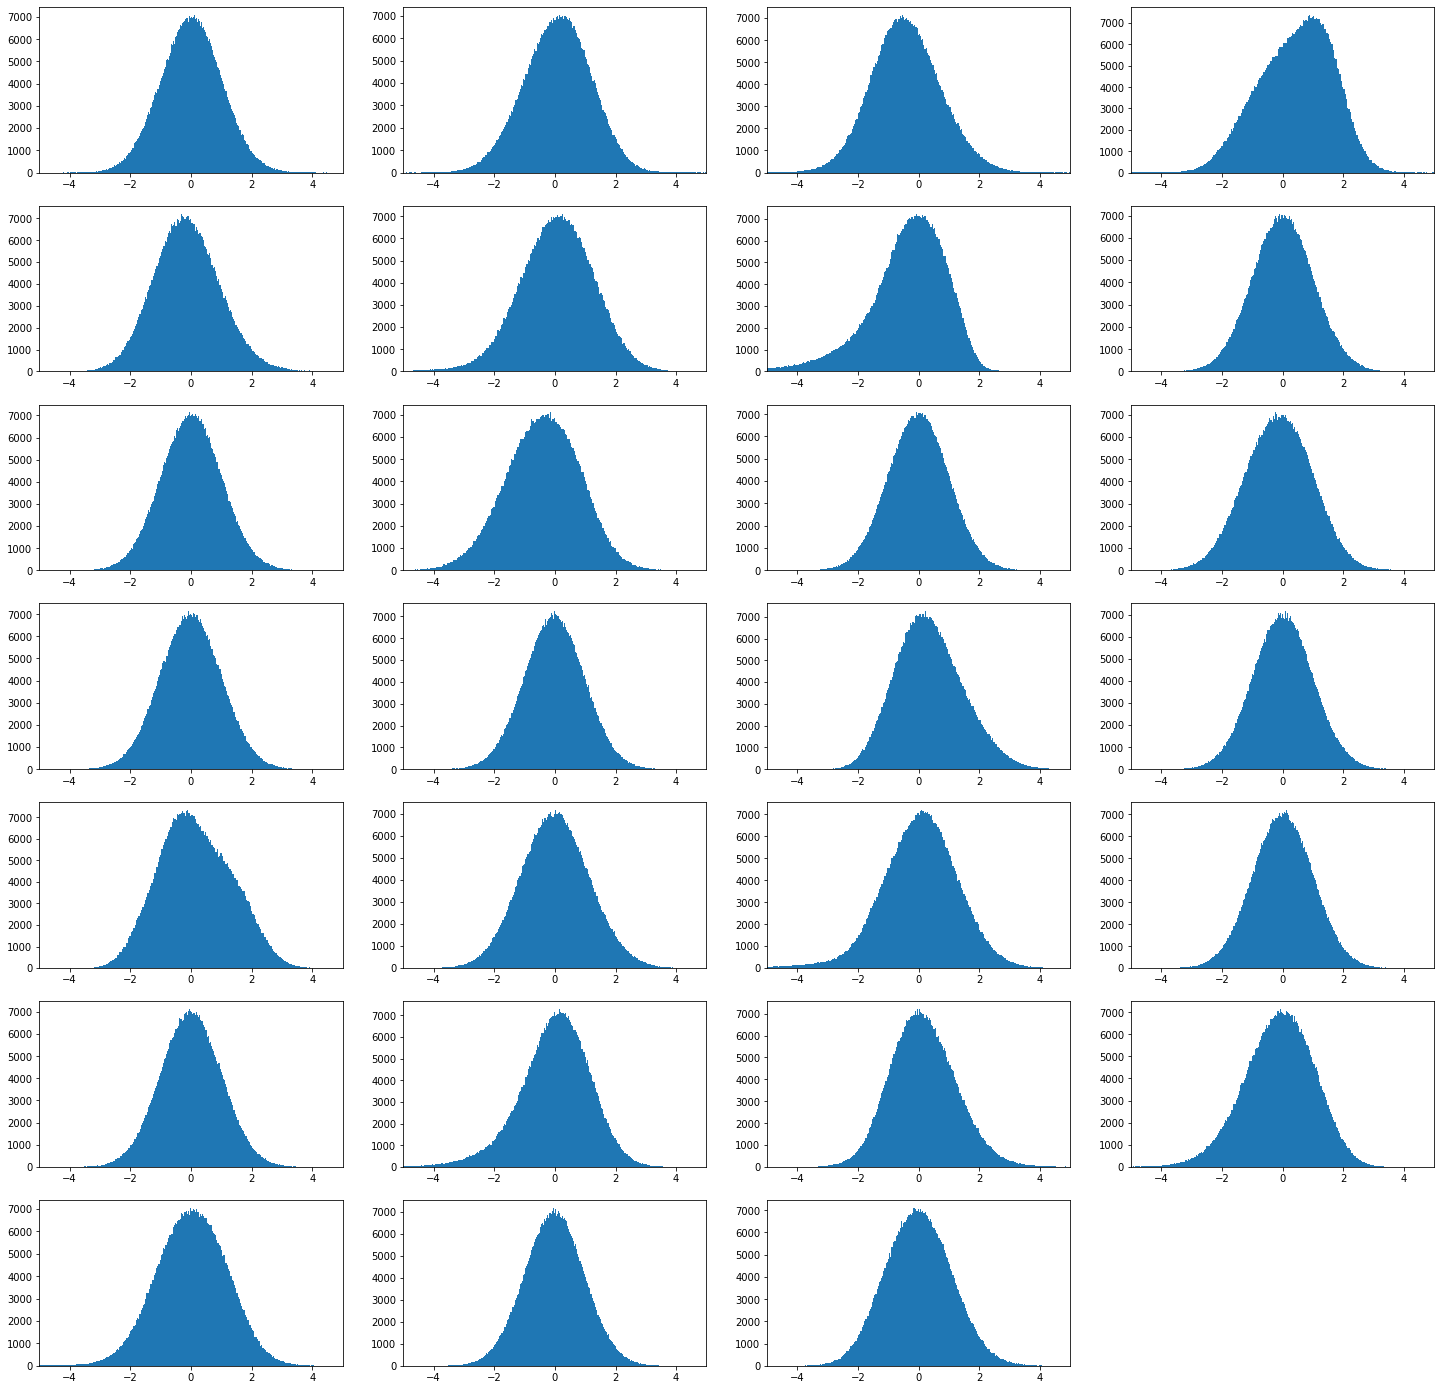

In [14]:

fig = plt.figure(figsize=[25,25])
i = 0

for x in range(hidden.shape[1]):
    axes = fig.add_subplot(7,4,i+1)
    i += 1

    axes.hist(hidden[:, x], bins='auto')
    axes.axis(xmin=-5,xmax=5)
    #axes.title(f"Z{x}")
    print("Mean:", hidden[:, x].mean(), "\tStd:", hidden[:, x].std())


fig.show()

## Random sampling and comparing distributions with bkg data

In [15]:
bkg.drop(columns=['name'], inplace=True)

In [16]:

# Random sample from N(0,1)
sample = model.decode(torch.rand(bkg.shape[0], study.best_trial.params['hidden_size'])).detach().numpy()

# Make it a dataframe
sample = pd.DataFrame(sample, columns=bkg.columns)
sample.describe()

FatJet_Multi     FatJet1_PT     FatJet2_PT     FatJet3_PT  \
count  370198.000000  370198.000000  370198.000000  370198.000000   
mean       -0.416066      -0.170894      -0.630055      -0.322396   
std         0.254354       0.226819       0.302457       0.030201   
min        -1.607318      -1.546623      -1.681178      -0.439636   
25%        -0.579133      -0.284159      -0.855630      -0.342995   
50%        -0.371870      -0.118014      -0.624481      -0.321005   
75%        -0.225755      -0.024241      -0.400819      -0.300868   
max         0.892519       0.748113       0.846564      -0.212093   

          FatJet4_PT     FatJet5_PT   FatJet1_Mass   FatJet2_Mass  \
count  370198.000000  370198.000000  370198.000000  370198.000000   
mean       -0.085891      -0.029528      -0.569845      -0.489317   
std         0.009501       0.004645       0.220528       0.225968   
min        -0.131573      -0.051690      -1.433348      -1.269597   
25%        -0.091951      -0.032707      -0.722066      -0.660760   
50%        -0.085309      -0.029519      -0.568587      -0.486381   
75%        -0.079207      -0.026344      -0.417300      -0.313540   
max        -0.051114      -0.008331       0.815978       0.545875   

        FatJet3_Mass   FatJet4_Mass  ...  Electron_Multi   Electron1_PT  \
count  370198.000000  370198.000000  ...   370198.000000  370198.000000   
mean       -0.277472      -0.053147  ...        0.021386       0.331678   
std         0.022573       0.010243  ...        0.164450       0.394822   
min        -0.373032      -0.093044  ...       -0.404184      -0.317458   
25%        -0.292575      -0.059943  ...       -0.021070      -0.004148   
50%        -0.275908      -0.052583  ...       -0.010129       0.228562   
75%        -0.261220      -0.045813  ...       -0.002416       0.610720   
max        -0.200589      -0.019847  ...        1.283560       2.062855   

        Electron2_PT  Electron1_Eta  Electron2_Eta  Electron1_Phi  \
count  370198.000000  370198.000000  370198.000000  370198.000000   
mean       -0.179123      -0.087386      -0.126919       0.430613   
std         0.053549       0.170528       0.137548       0.506472   
min        -0.396946      -1.022014      -1.043178      -0.035097   
25%        -0.213432      -0.163997      -0.187955      -0.003765   
50%        -0.177845      -0.027200      -0.052460       0.239835   
75%        -0.142092      -0.006318      -0.032296       0.773870   
max        -0.008665       1.353826      -0.004631       2.929976   

       Electron2_Phi  MissingET_MET  MissingET_Phi    ScalarHT_HT  
count  370198.000000  370198.000000  370198.000000  370198.000000  
mean       -0.138235      -0.354274       0.859943      -0.211733  
std         0.105785       0.081832       0.328221       0.183395  
min        -0.606649      -0.686425      -0.255728      -0.984757  
25%        -0.209834      -0.410750       0.692228      -0.346018  
50%        -0.128070      -0.354555       0.883288      -0.200334  
75%        -0.050525      -0.297897       1.074536      -0.068202  
max         1.165870      -0.014015       1.928590       0.774290  

[8 rows x 69 columns]

In [17]:
def plot_graphs2(background, signal, bins=50, num_cols=4):

    # Ignoring irrelevant features such as 'name' and 'weights' in
    # the plotting of the data
    features  = list(background.columns)
    for x in ['name', 'weights']: 
        try:
            features.remove(x)
        except:
            pass

    # Plot creation
    num_rows = int(np.ceil((len(list(signal.columns)) - 1) / num_cols)) +1
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(40, 60))
    i= 0

    for x in tqdm(features, total=len(features), desc="Processing..."):

        # Plot  
        row, col = int(i/num_cols), i%num_cols
        #print(row, col, i)
        i += 1


        # Define histogram range
        hist_min = min(signal[x].min(), background[x].min())
        hist_max = max(signal[x].max(), background[x].max())
        hist_range = (hist_min, hist_max)


        ax[row, col].set_title(x)
        ax[row, col].set_yscale('log')
        
        ax[row, col].hist(background[x], bins=bins, alpha=0.5, label='Real', range=hist_range)
        ax[row, col].hist(signal[x], bins=bins, alpha=0.5, label='Sampled',  range=hist_range)
        
        ax[row, col].autoscale(enable=True) 
        ax[row, col].legend()
        

    fig.tight_layout()
    #plt.savefig('1_explore_data.png', bbox_inches='tight', dpi=100)
    plt.show()
    

Processing...:   0%|          | 0/69 [00:00<?, ?it/s]

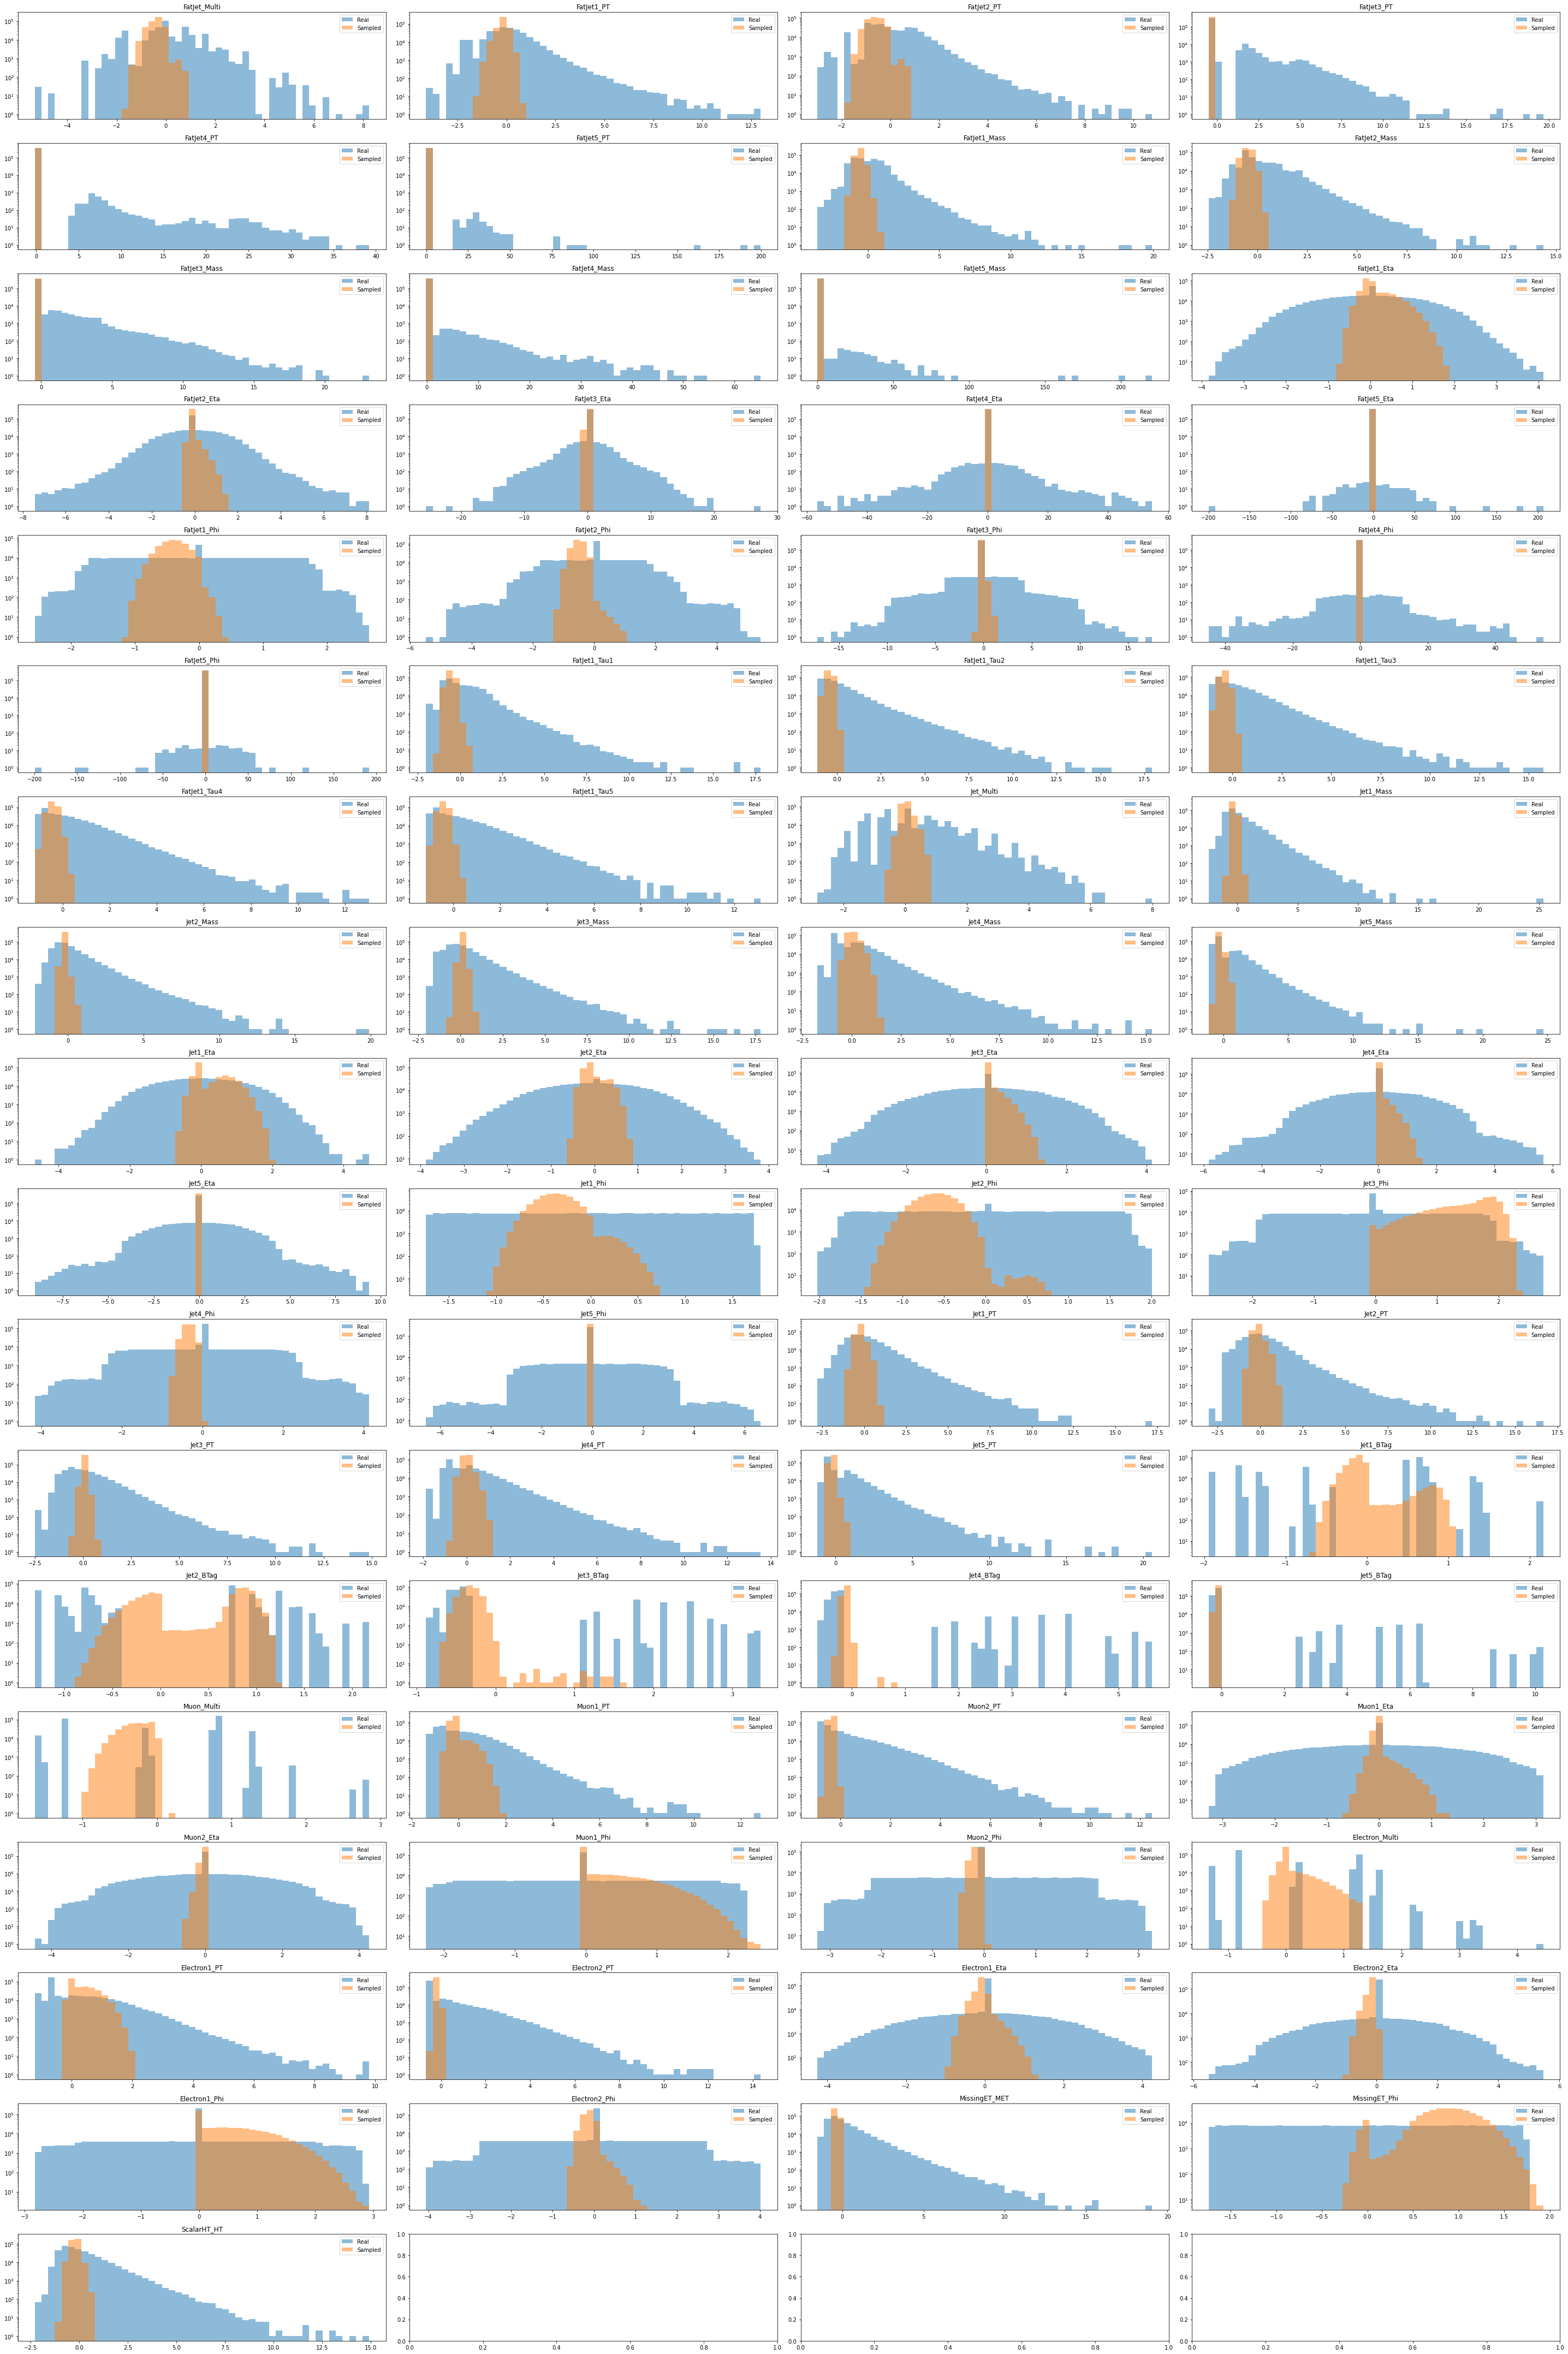

In [18]:
plot_graphs2(bkg, sample)

Plot latent space

  0%|          | 0/6 [00:00<?, ?it/s]

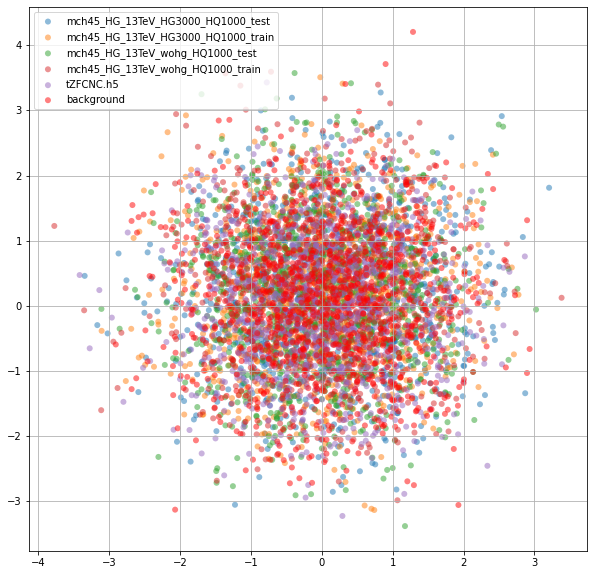

In [19]:
fig, ax = plt.subplots( figsize=(10,10))
for x in tqdm(data['name'].unique()):
    mu, log_var, x_out, hidden = model.test_step(torch.from_numpy(data.loc[data['name'] == x].drop(columns=['name']).to_numpy(dtype=np.float32)))
    hidden = hidden.detach().numpy()

    if x != 'background.csv':
        color = None
    else:
        color = 'r'

    ax.scatter(hidden[:1000, 0], hidden[:1000, 1], label=x.replace('.csv', ''), alpha=0.5, edgecolors='none', c = color)

ax.legend()
ax.grid(True)

plt.show()
